# **Problem Statement**

##Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. The Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

##Objective

To identify different segments in the existing customers, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


##Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online, and through a call center).

Data Dictionary

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that the customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

# **Importing the necessary libraries**

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# **Loading the dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Read the data
data = pd.read_excel('/content/drive/MyDrive/PGPDSA/Credit_Card_Customer_Data.xlsx')
#returns first 5 rows
data.head(5)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


## Creating a copy of original data

In [4]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [5]:
# we will drop the Sl_No column as it adds no value to the analysis
df.drop("Sl_No", axis=1, inplace=True)

# **Data Overview**

###1. Structure of Data

In [6]:
df.shape

(660, 6)

###2. Type of Data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 31.1 KB


###3. Missing values treatment

In [8]:
df.isnull().sum()

,0
Customer Key,0
Avg_Credit_Limit,0
Total_Credit_Cards,0
Total_visits_bank,0
Total_visits_online,0
Total_calls_made,0


###4. Data Duplicates

In [9]:
df.duplicated().sum()

0

In [10]:
df.columns

Index(['Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')

###5. Statistical Summary

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.5,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.0,10.0


##Insights

* Serial Number and Customer identification number are unique, hence will not add value to the modeling.
* The average credit limit is 34,574, but the maximum reaches 200,000. The wide range (3,000 to 200,000) and high standard deviation (37,625) indicate that there are customers with very high credit limits compared to others. This might imply the presence of both high-value customers and potentially risky customers within the dataset.

* Customers hold an average of approximately 4.7 credit cards, with most customers having between 3 to 6 cards. The maximum of 10 cards suggests that a segment of customers may be over-leveraged, which could be a target for risk assessment.

* On average, customers visit the bank about 2.4 times, with a range from 0 to 5 visits. A substantial proportion of customers may prefer online interactions, as indicated by the low average number of bank visits.

* The average number of online visits is slightly higher at 2.6, with a maximum of 15 visits. This suggests a growing trend toward online banking, which may influence customer engagement strategies.

* Customers make an average of 3.6 calls, with most calls falling between 1 to 5. The significant standard deviation indicates some customers may rely heavily on customer service, possibly reflecting dissatisfaction or a need for assistance.

# **Exploratory Data Analysis**

In [12]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    ax_hist2.set_title(f'Distribution of {feature}')

In [13]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    ax.set_title(f'Distribution of {feature}')
    plt.show()  # show the plot

In [14]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.title(f'Stacked Bar Plot of {predictor} vs {target}')
    plt.show()

In [15]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'Distribution and Boxplots of {predictor} with respect to {target}', fontsize=16)


    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

###Univariate Analysis

####Observation on Avg_Credit_Limit

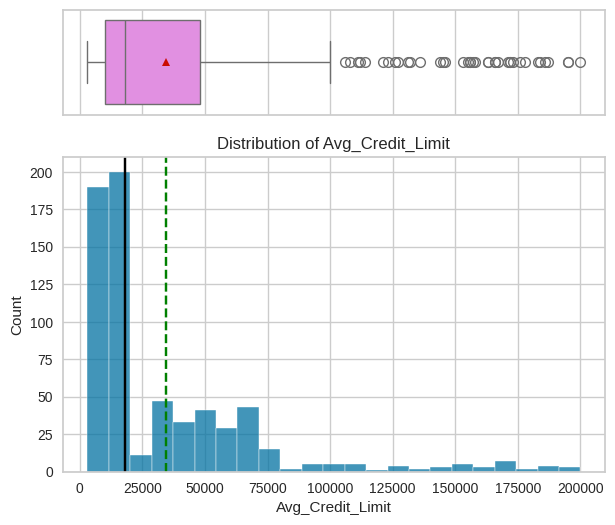

In [16]:
histogram_boxplot(df, "Avg_Credit_Limit",figsize=(7,6))

####Observation on Total_Credit_Cards

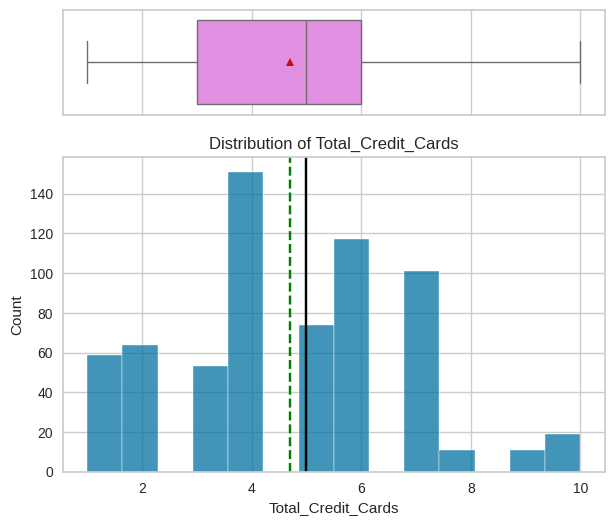

In [17]:
histogram_boxplot(df, "Total_Credit_Cards",figsize=(7,6))

####Observation on Total_visits_bank

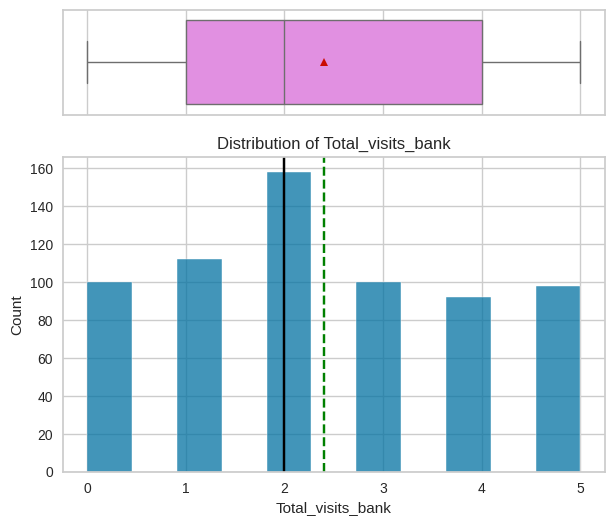

In [18]:
histogram_boxplot(df, "Total_visits_bank",figsize=(7,6))

####Observation on Total_visits_online

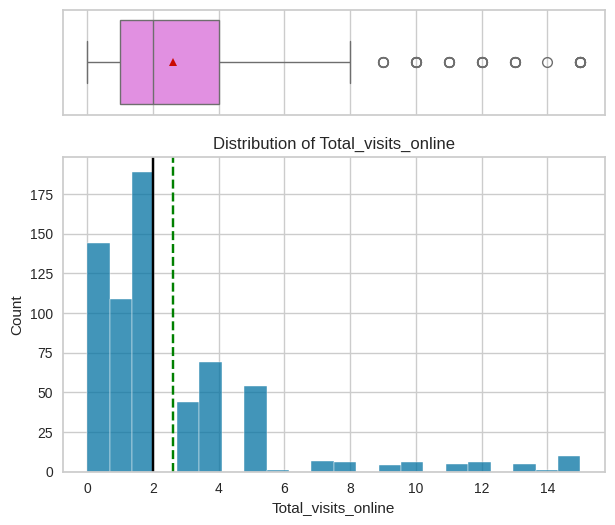

In [19]:
histogram_boxplot(df, "Total_visits_online",figsize=(7,6))

####Observation on Total_calls_made

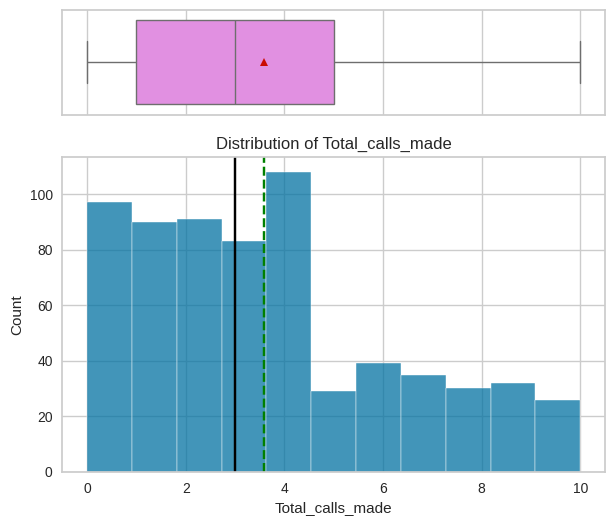

In [20]:
histogram_boxplot(df, "Total_calls_made",figsize=(7,6))

####Insights

* The data shows a wide range of average credit limits among customers, with a significant portion having lower limits and a smaller group having much higher limits.

* The box plot suggests a right-skewed distribution, meaning there are a few customers with very high credit limits, pulling the tail to the right.

* The data shows a concentration of customers with a moderate number of credit cards.

*  The histogram confirms the slight right-skewness observed in the box plot. The majority of customers have between 4 and 6 credit cards, with a decreasing frequency as the number of credit cards increases.

* The histogram confirms the slight right-skewness observed in the box plot. The majority of customers visit the bank between 2 and 3 times, with a decreasing frequency as the number of visits increases.

* The box plot suggests a slight right-skewness, meaning there are a few customers with a larger number of online visits, pulling the tail to the right.

* The median number of total visits online is around 2. This suggests that 50% of customers visit online two times or fewer.

* The histogram confirms the slight right-skewness observed in the box plot. The majority of customers make between 3 and 5 calls, with a decreasing frequency as the number of calls increases.


In [21]:
df.columns

Index(['Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')

###Bivariate Analysis

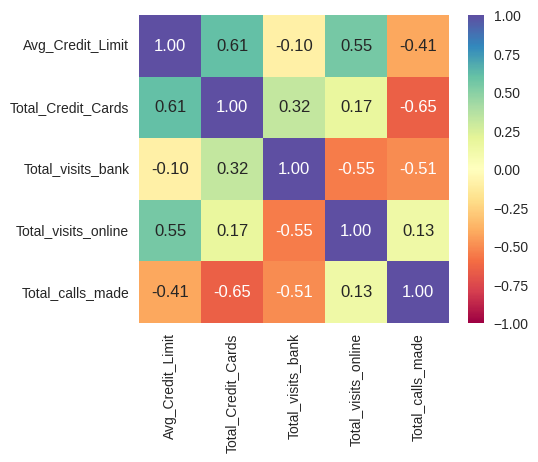

In [22]:
cols_list = df.select_dtypes(include=np.number).columns.tolist()
cols_list.remove("Customer Key")
plt.figure(figsize=(5, 4))
sns.heatmap(
    df[cols_list].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

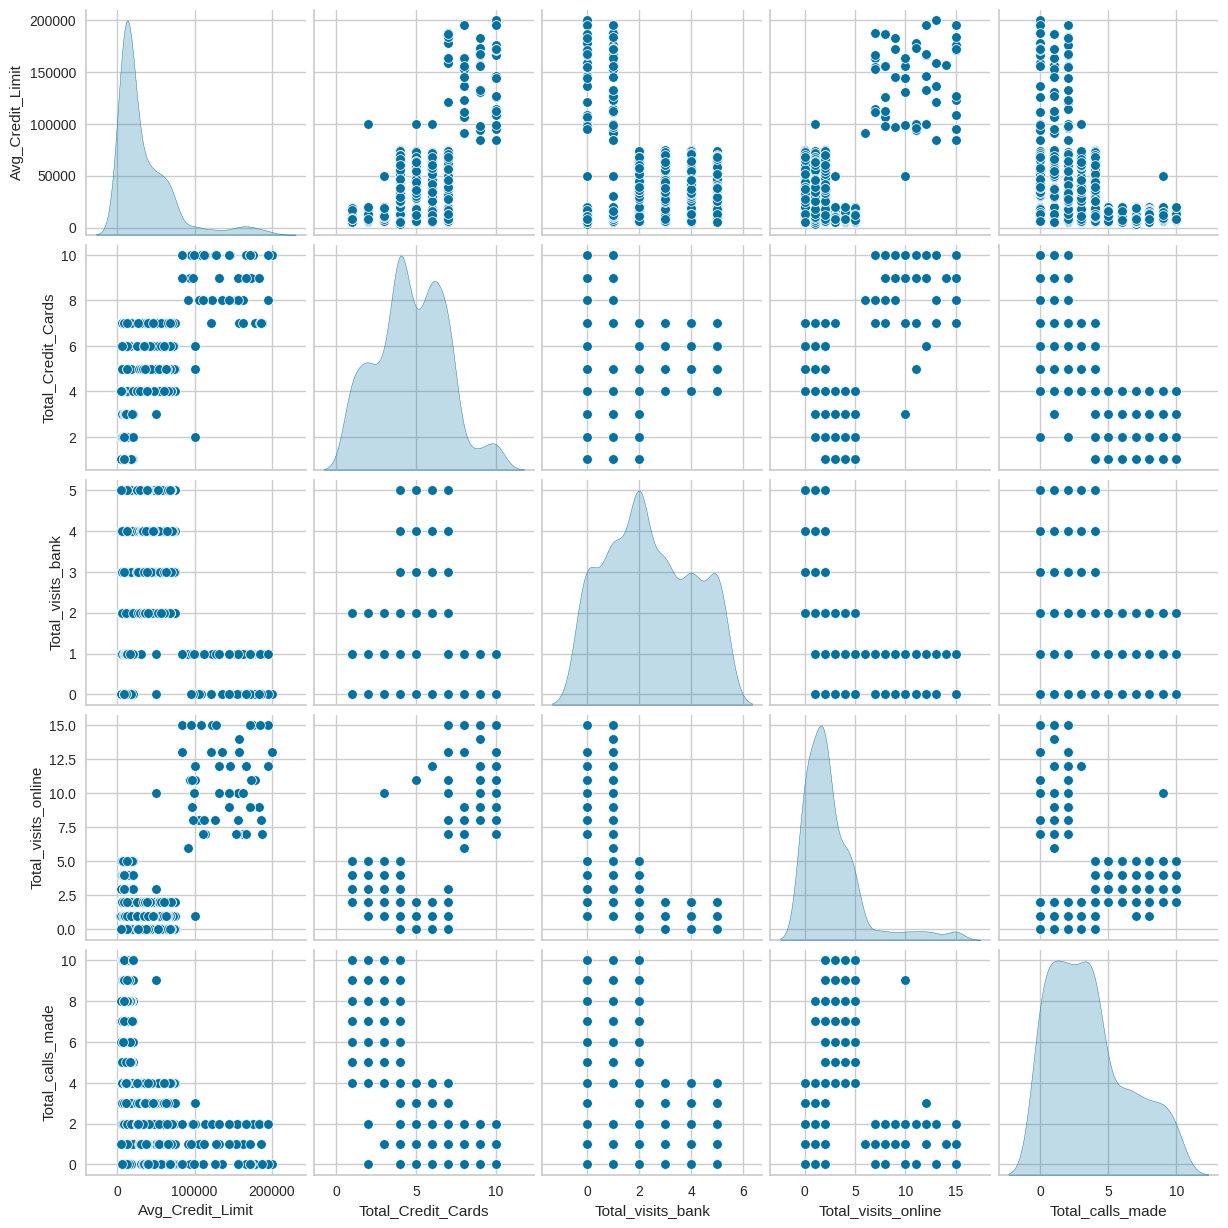

In [65]:
sns.pairplot(data=df[cols_list], diag_kind="kde")
plt.show()

####Insights

Positive Correlations:

1. Avg_Credit_Limit and Total_Credit_Cards: There's a strong positive correlation between average credit limit and the number of credit cards, suggesting that customers with higher credit limits tend to have more credit cards.
2. Total_visits_online and Total_calls_made: A moderate positive correlation exists between online visits and calls made, indicating that customers who visit online more frequently are also more likely to make calls.

Negative Correlations:

1. Total_visits_bank and Total_visits_online: There's a strong negative correlation between visits to the bank and online visits, suggesting that customers who visit the bank frequently tend to visit online less often.
2. Total_visits_bank and Total_calls_made: A moderate negative correlation exists between bank visits and calls made, indicating that customers who visit the bank frequently are less likely to make calls.


No Significant Correlations: There are no significant correlations between Total_Credit_Cards and Total_visits_bank, Total_Credit_Cards and Total_visits_online, and Total_Credit_Cards and Total_calls_made.

# **Data Preprocessing**

### Missing values treatment

In [23]:
df.isnull().sum()

,0
Customer Key,0
Avg_Credit_Limit,0
Total_Credit_Cards,0
Total_visits_bank,0
Total_visits_online,0
Total_calls_made,0


### Outlier Check

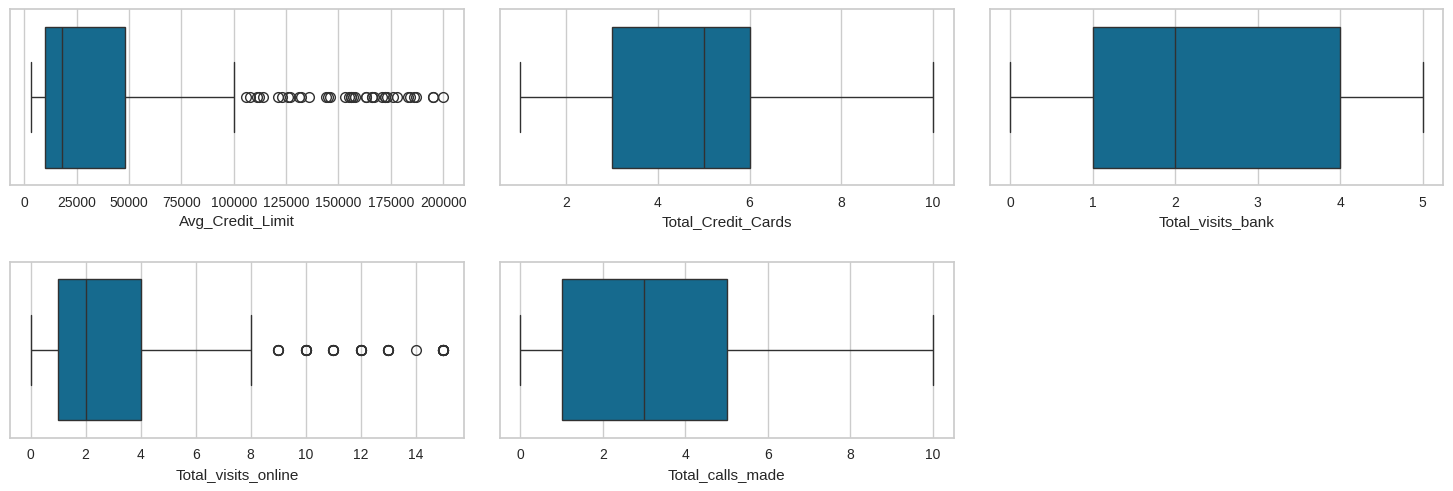

In [24]:
# outlier detection using boxplot
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols.pop(0)
plt.figure(figsize=(15, 10))

for i, variable in enumerate(num_cols):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(data=df, x=variable)
    plt.tight_layout(pad=2)

plt.show()

In [25]:
Q1 = df['Avg_Credit_Limit'].quantile(0.25)
Q3 = df['Avg_Credit_Limit'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [26]:
IQR


38000.0

In [27]:
lower_bound

-47000.0

In [28]:
upper_bound

105000.0

In [29]:
outliers = df[(df['Avg_Credit_Limit'] < lower_bound) | (df['Avg_Credit_Limit'] > upper_bound)]


In [30]:
outliers

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
612,94391,157000,9,1,14,1
614,40019,163000,8,1,7,1
615,77910,131000,9,1,10,1
617,98216,136000,8,0,13,0
618,54495,121000,7,0,13,2
619,47650,158000,7,0,13,0
620,32107,108000,10,0,15,1
621,84192,166000,9,1,12,2
622,53916,176000,10,1,15,2
623,32584,166000,10,0,7,0


These customers have average credit limits that are significantly higher than the rest of the population. However, this could reflect their genuine circumstances, so we shouldn't remove the outliers. It ultimately depends on each individual's financial and professional situation.

In [31]:
df.columns

Index(['Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')

### Feature Engineering

In [32]:
to_scale=df.drop(columns=[ 'Customer Key'])


We are removing Customer Key from the DataFrame, as they do not contribute meaningful value to the clustering process.

In [33]:
to_scale

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3
...,...,...,...,...,...
655,99000,10,1,10,0
656,84000,10,1,13,2
657,145000,8,1,9,1
658,172000,10,1,15,0


### Scaling

- Let's scale the data before we proceed with clustering.

In [34]:
sc = StandardScaler()
subset_scaled_df = pd.DataFrame(
    sc.fit_transform(to_scale),
    columns=to_scale.columns,
)
subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


In [35]:
km_df = df.copy()
hc_df = df.copy()

# **K-means Clustering**

###Plot the Elbow curve

Number of Clusters: 1 	Average Distortion: 2.006922226250361
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774463
Number of Clusters: 5 	Average Distortion: 0.9984086474611271
Number of Clusters: 6 	Average Distortion: 0.9651175868007105
Number of Clusters: 7 	Average Distortion: 0.9259135376350698
Number of Clusters: 8 	Average Distortion: 0.9211835468499175
Number of Clusters: 9 	Average Distortion: 0.8752234180939921
Number of Clusters: 10 	Average Distortion: 0.8505796034595803
Number of Clusters: 11 	Average Distortion: 0.8350921089299926


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

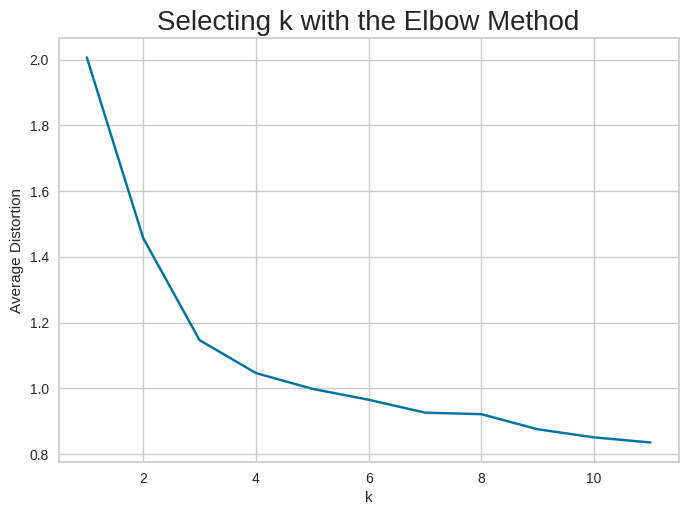

In [36]:
clusters = range(1, 12)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**The appropriate value of k from the elbow curve seems to be 3 or 4.**

### Let's check the silhouette scores

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.3284672118706534
For n_clusters = 6, silhouette score is 0.24806123278744782
For n_clusters = 7, silhouette score is 0.24633384025835273
For n_clusters = 8, silhouette score is 0.23241103950361397
For n_clusters = 9, silhouette score is 0.2237028865804097
For n_clusters = 10, silhouette score is 0.21150786170622632
For n_clusters = 11, silhouette score is 0.20800747719844545


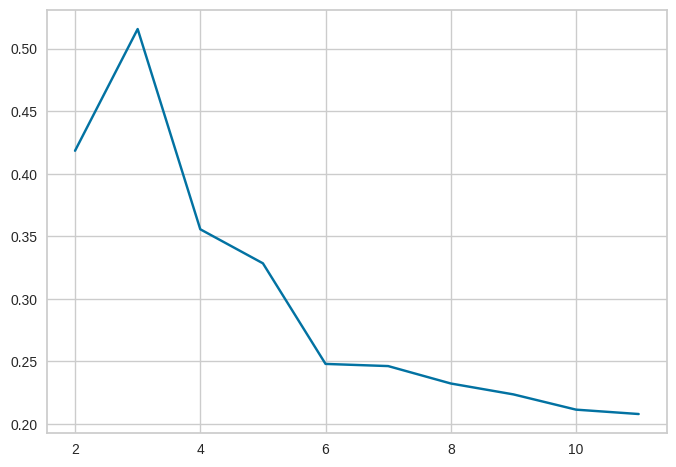

In [37]:
sil_score = []
cluster_list = list(range(2, 12))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 3 is a good value of k.**

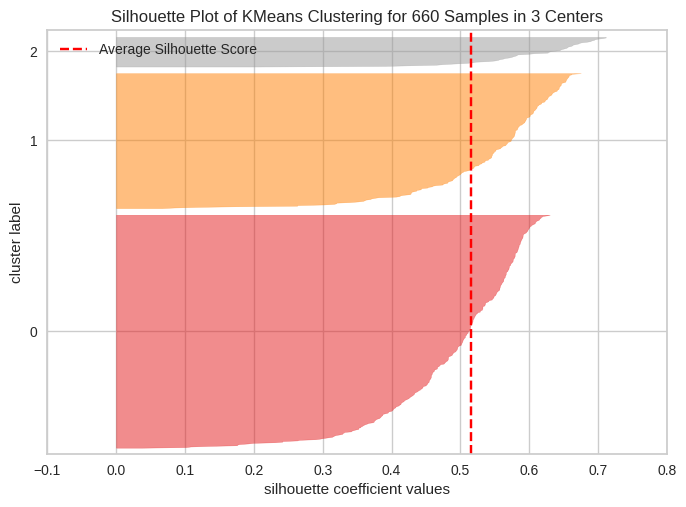

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [38]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

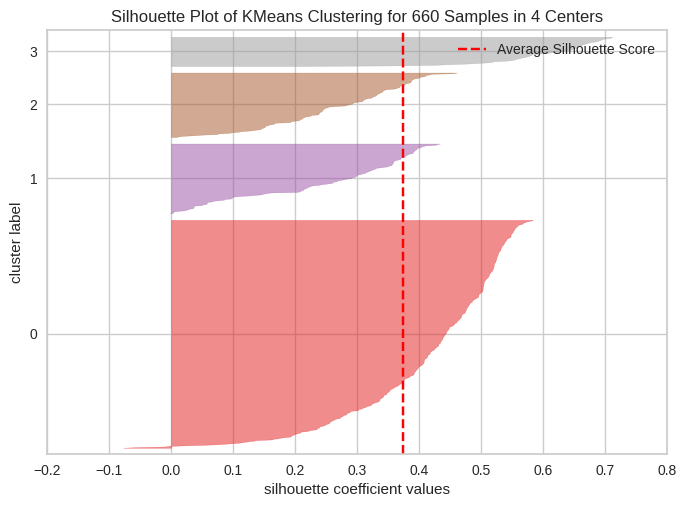

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [39]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

### Selecting final model

**Let's take 3 as the appropriate no. of clusters as the silhouette score is high enough and there is knick at 3 in the elbow curve.**

In [40]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=0)

In [41]:
# adding kmeans cluster labels to the original dataframe
km_df["K_means_segments"] = kmeans.labels_

In [42]:
km_df

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
0,87073,100000,2,1,1,0,0
1,38414,50000,3,0,10,9,1
2,17341,50000,7,1,3,4,0
3,40496,30000,5,1,1,4,0
4,47437,100000,6,0,12,3,2
...,...,...,...,...,...,...,...
655,51108,99000,10,1,10,0,2
656,60732,84000,10,1,13,2,2
657,53834,145000,8,1,9,1,2
658,80655,172000,10,1,15,0,2


### Cluster Profiling

In [43]:
km_df["K_means_segments"].value_counts()

,count
K_means_segments,
0,386
1,224
2,50



* The majority of customers are in Cluster 0, while a smaller number belong to Cluster 2.

In [44]:
clusters = km_df.K_means_segments.unique().tolist()
for cl in clusters:
    print(
        "The",
        km_df[km_df["K_means_segments"] == cl]["Customer Key"].nunique(),
        "customers in cluster",
        cl,
        "are:",
    )
    print(km_df[km_df["K_means_segments"] == cl]["Customer Key"].unique())
    print("-" * 100, "\n")

The 384 customers in cluster 0 are:
[87073 17341 40496 54838 35254 46635 97825 83125 35483 15129 83290 56486
 31903 45909 14263 46813 81878 35549 85799 39122 81531 69965 18595 44398
 32352 40898 27101 33457 45088 23302 27408 65372 21531 56843 17165 89328
 20072 71402 47496 24808 17036 67193 34423 97109 55382 51811 53936 66504
 53207 18514 51319 36340 36934 95925 49771 22919 21233 74544 52025 45652
 73952 49418 77026 49331 75775 54906 94666 11698 34677 95610 41380 38033
 85337 38994 67911 92956 77641 57565 53814 30712 19785 31384 16374 50878
 78002 83459 91987 51552 24998 45673 11596 87485 28414 81863 33240 11466
 23881 44645 49844 92782 22824 26767 26678 50412 17933 34495 47437 22610
 41159 64672 62483 85614 96548 19137 69028 70779 38244 67046 64897 46223
 36628 17565 77381 11799 81940 66706 87838 94437 33790 44402 29886 66804
 47866 61996 15318 89635 71681 71862 96186 22348 36243 88807 82376 98126
 80347 17649 62807 92522 57459 44579 45476 61994 11398 24702 27824 45878
 72431 19215 23

In [45]:
cluster_profile = km_df.groupby("K_means_segments")[cols_list].mean()

In [46]:
cluster_profile["count_in_each_segment"] = (
    km_df.groupby("K_means_segments")["Customer Key"].count().values
)

In [47]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


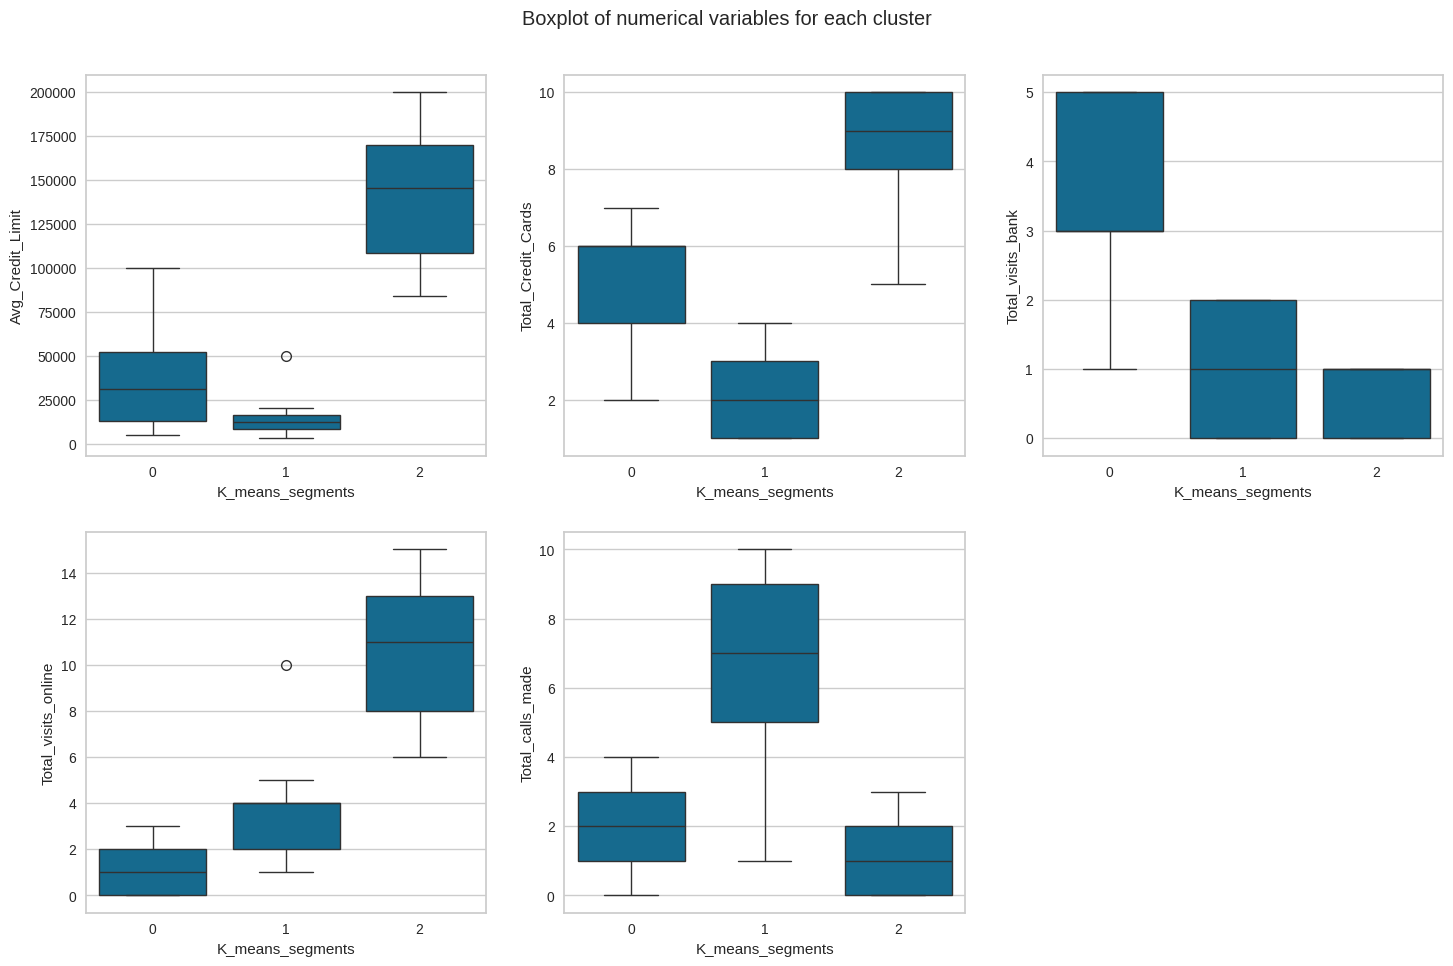

In [48]:
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(cols_list):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=km_df, x="K_means_segments", y=variable)

plt.tight_layout(pad=2.0)

<Axes: xlabel='K_means_segments'>

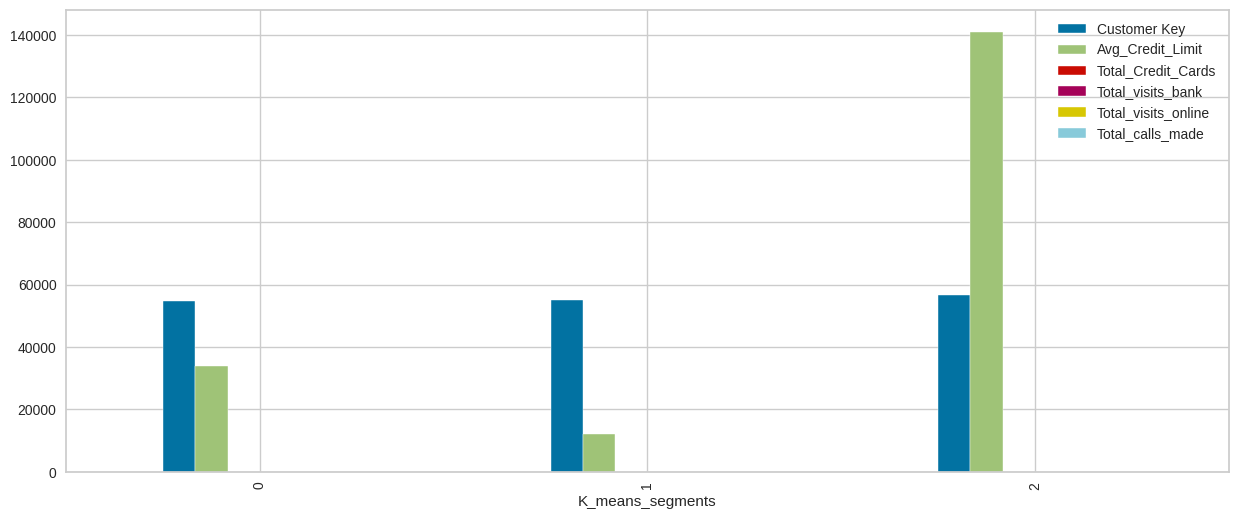

In [49]:
km_df.groupby("K_means_segments").mean(numeric_only = True).plot.bar(figsize=(15, 6))

In [50]:
km_df

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
0,87073,100000,2,1,1,0,0
1,38414,50000,3,0,10,9,1
2,17341,50000,7,1,3,4,0
3,40496,30000,5,1,1,4,0
4,47437,100000,6,0,12,3,2
...,...,...,...,...,...,...,...
655,51108,99000,10,1,10,0,2
656,60732,84000,10,1,13,2,2
657,53834,145000,8,1,9,1,2
658,80655,172000,10,1,15,0,2


###Insights

#### Cluster 0: Moderate Engagement
* Avg_Credit_Limit: Moderate credit limit, generally between 50,000 and 100,000.
* Total_Credit_Cards: Holds around 4–6 credit cards.
* Total_visits_bank: Frequently visits the bank, typically around 4–5 visits.
* Total_visits_online: Makes around 2–4 online visits, with low online engagement.
* Total_calls_made: Moderately engaged via calls, making 2–4 calls.


Summary: This cluster likely represents users with moderate engagement across all channels. They have a mid-range credit limit, visit the bank frequently, and show balanced online activity and call frequency.

#### Cluster 1: Low Engagement
* Avg_Credit_Limit: The lowest credit limit, ranging between 10,000 and 25,000.
* Total_Credit_Cards: Holds only 1–2 credit cards, suggesting minimal involvement with credit services.
* Total_visits_bank: Rarely visits the bank, with just 1 visit.
* Total_visits_online: Makes slightly more online visits than bank visits, around 3–4 times, but still relatively low.
* Total_calls_made: Rarely makes calls, with around 1–2 calls.

Summary: This cluster likely represents low-engagement customers with minimal credit limit, fewer credit cards, and limited interaction through both bank visits and calls. They may need targeted marketing to increase their engagement.



#### Cluster 2: High Engagement
* Avg_Credit_Limit: The highest credit limit, often above 150,000 and up to 200,000.
* Total_Credit_Cards: Holds around 8–10 credit cards, reflecting extensive use of credit products.
* Total_visits_bank: Very few bank visits (1 or fewer), indicating a preference for other channels of interaction.
* Total_visits_online: Extremely active online, with frequent visits (around 10–14).
* Total_calls_made: High engagement through calls, making 7–9 calls regularly.

Summary: This cluster represents high-value customers with significant credit limits, numerous credit cards, and a preference for online and phone interactions over bank visits. They are highly engaged and represent a prime target for premium products or services.

# **Hierarchical Clustering**

### Computing Cophenetic Correlation

In [51]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553605.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875359.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

In [52]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


### Checking Dendrograms

**We see that the cophenetic correlation is maximum with Euclidean distance and average linkage.**


**Let's view the dendrograms for the different linkage methods.**

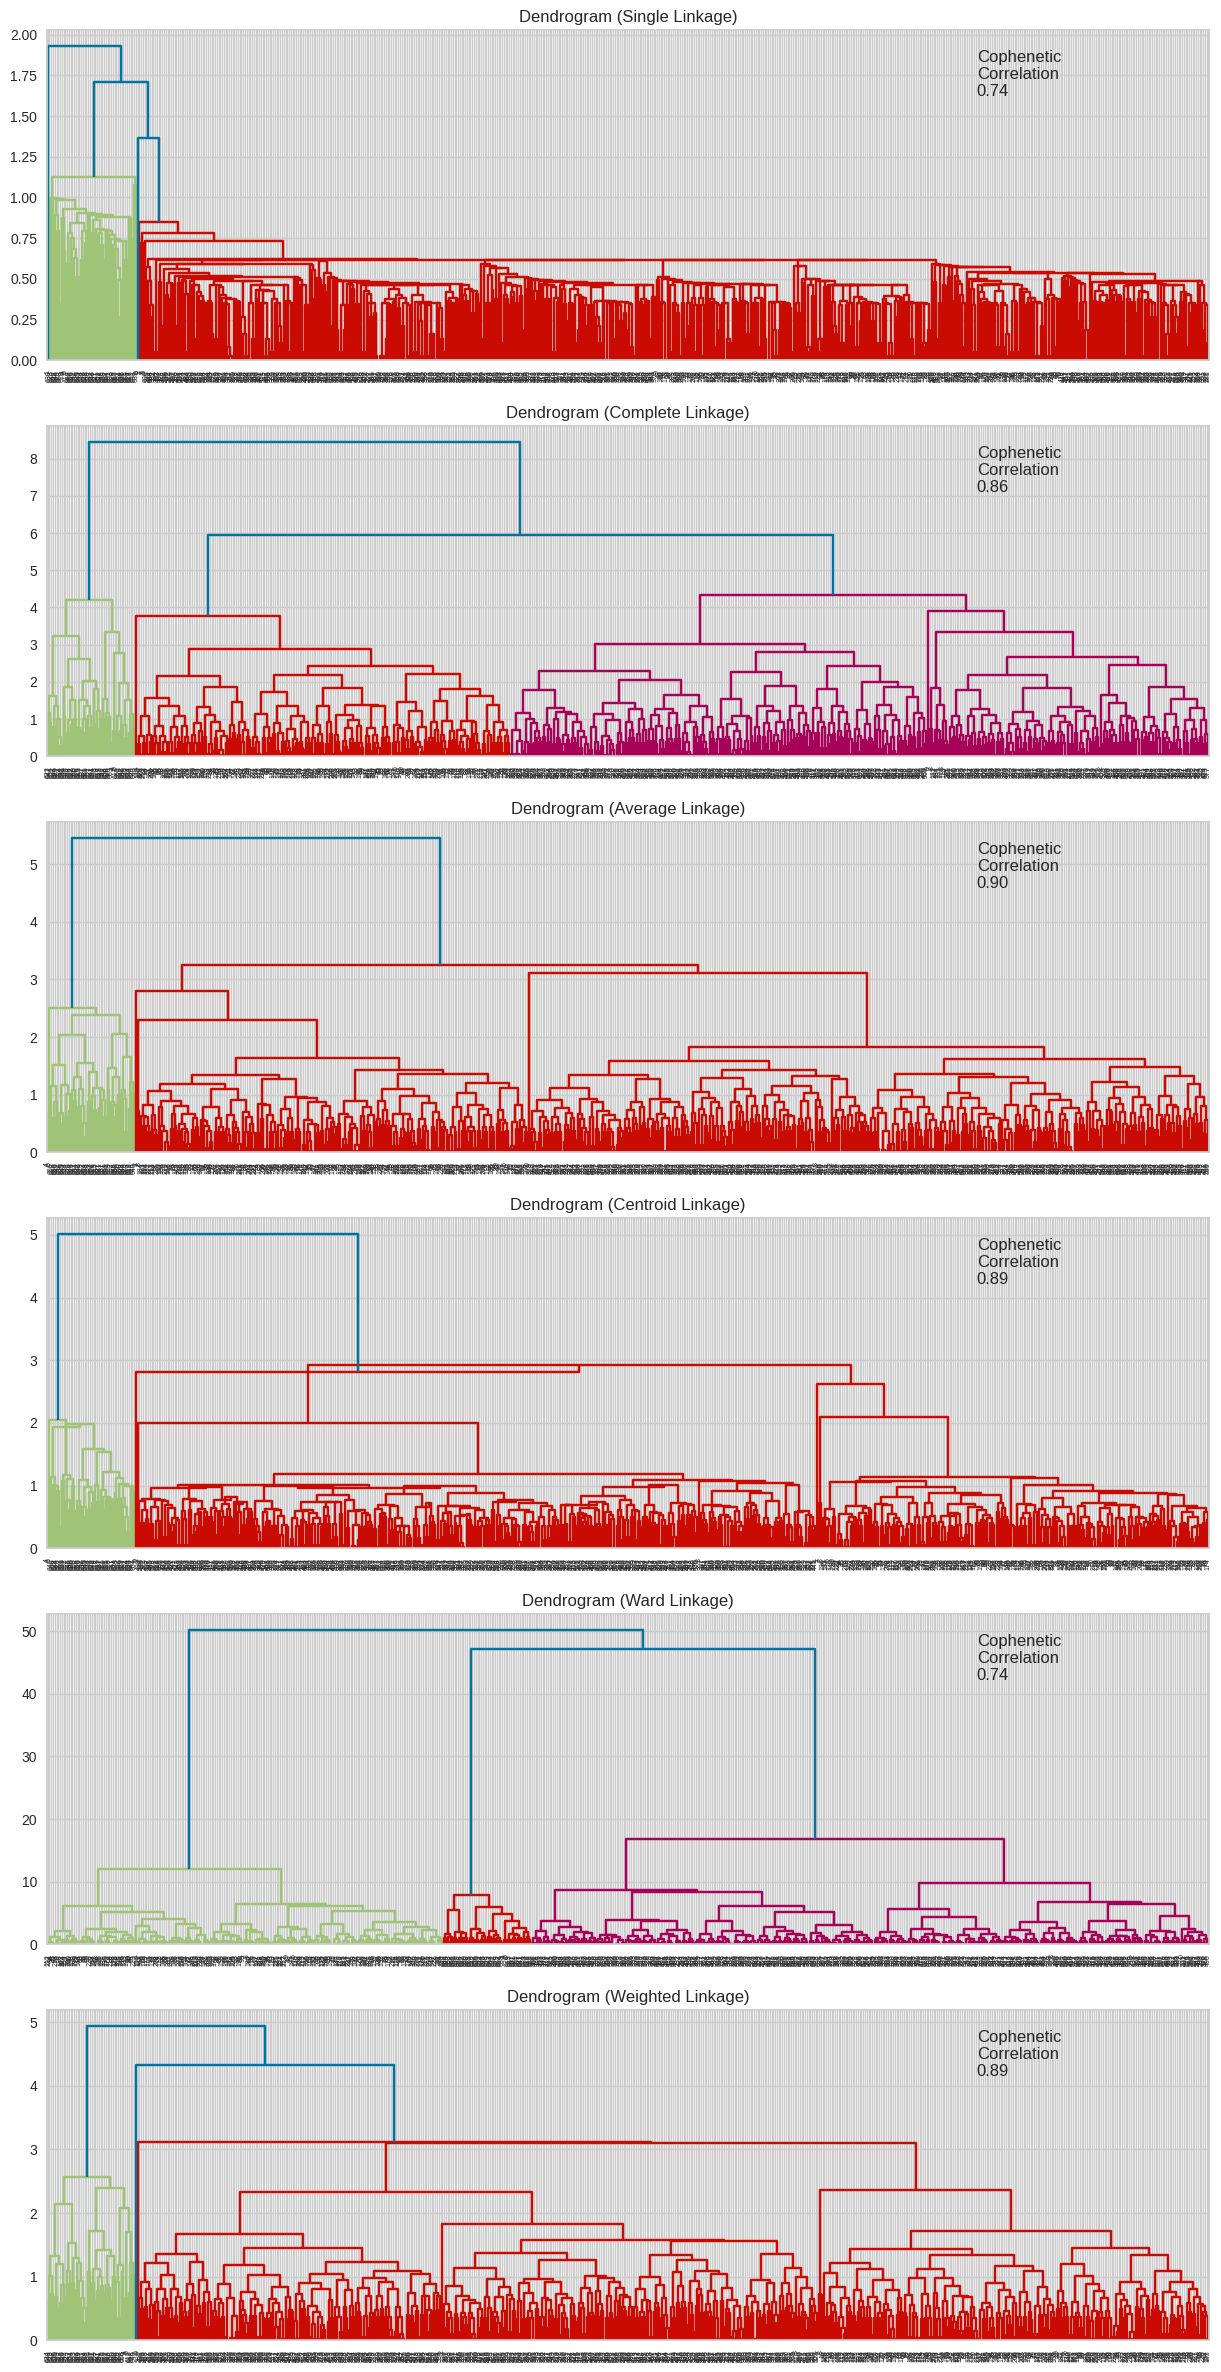

In [53]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

**Observations:**
- Based on the dendrograms, the Ward linkage appears to provide the best cluster separation, despite having a lower cophenetic correlation compared to other linkages.
- Choosing 4 clusters seems to be a good option.

### Creating Final Model

In [54]:
hc = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="ward")
hc_labels = hc.fit_predict(subset_scaled_df)

In [55]:
hc_df["HC_segments"] = hc_labels

In [56]:
hc_df

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_segments
0,87073,100000,2,1,1,0,1
1,38414,50000,3,0,10,9,0
2,17341,50000,7,1,3,4,1
3,40496,30000,5,1,1,4,1
4,47437,100000,6,0,12,3,2
...,...,...,...,...,...,...,...
655,51108,99000,10,1,10,0,2
656,60732,84000,10,1,13,2,2
657,53834,145000,8,1,9,1,2
658,80655,172000,10,1,15,0,2


### Cluster Profiling

In [57]:
hc_df['HC_segments'].value_counts()

,count
HC_segments,
0,225
3,194
1,191
2,50


**Observations**

- Majority of the Customers belong to Cluster 0, 1 and 3.

In [58]:
clusters = hc_df.HC_segments.unique().tolist()
for cl in clusters:
    print(
        "The",
        hc_df[hc_df["HC_segments"] == cl]["Customer Key"].nunique(),
        "customers in cluster",
        cl,
        "are:",
    )
    print(hc_df[hc_df["HC_segments"] == cl]["Customer Key"].unique())
    print("-" * 100, "\n")

The 191 customers in cluster 1 are:
[87073 17341 40496 54838 35254 97825 35483 45909 14263 46813 39122 81531
 18595 40898 27101 45088 65372 56843 20072 47496 53936 66504 51319 21233
 74544 45652 77026 54906 94666 11698 34677 57565 31384 16374 91987 51552
 24998 45673 81863 23881 44645 17933 47437 85614 96548 19137 69028 64897
 36628 17565 11799 81940 66706 87838 47866 61996 15318 89635 71862 82376
 17649 44579 61994 24702 27824 45878 72431 19215 85122 55060 31113 68439
 88207 96929 78618 31551 29864 45440 97954 90189 55090 88884 45808 53932
 65908 25321 48602 48657 49913 53002 82807 93496 37252 41287 52460 58019
 87219 36839 12663 48667 42887 14439 81166 14816 11265 84351 89446 64774
 53166 45341 36504 15798 84360 46776 67258 44804 29919 74446 36632 76024
 75065 51682 56367 95147 23102 49690 20043 53552 62530 41741 61216 83192
 82023 64550 17382 27117 21717 81910 76492 43000 48692 43034 13140 91242
 63710 90860 58708 57451 43679 26334 47848 17377 51771 83585 68040 34775
 85645 44157 75

In [59]:
hc_df_profiling = hc_df.groupby("HC_segments")[cols_list].mean()
hc_df_profiling["count_in_each_segment"] = (
    hc_df.groupby("HC_segments")["Customer Key"].count().values
)

# displaying the group-wise means of variables
hc_df_profiling.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_segments,,,,,,
0,12151.111111,2.422222,0.937778,3.546667,6.857778,225
1,38298.429319,5.670157,2.523560,0.947644,2.099476,191
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,29474.226804,5.365979,4.448454,1.010309,1.891753,194


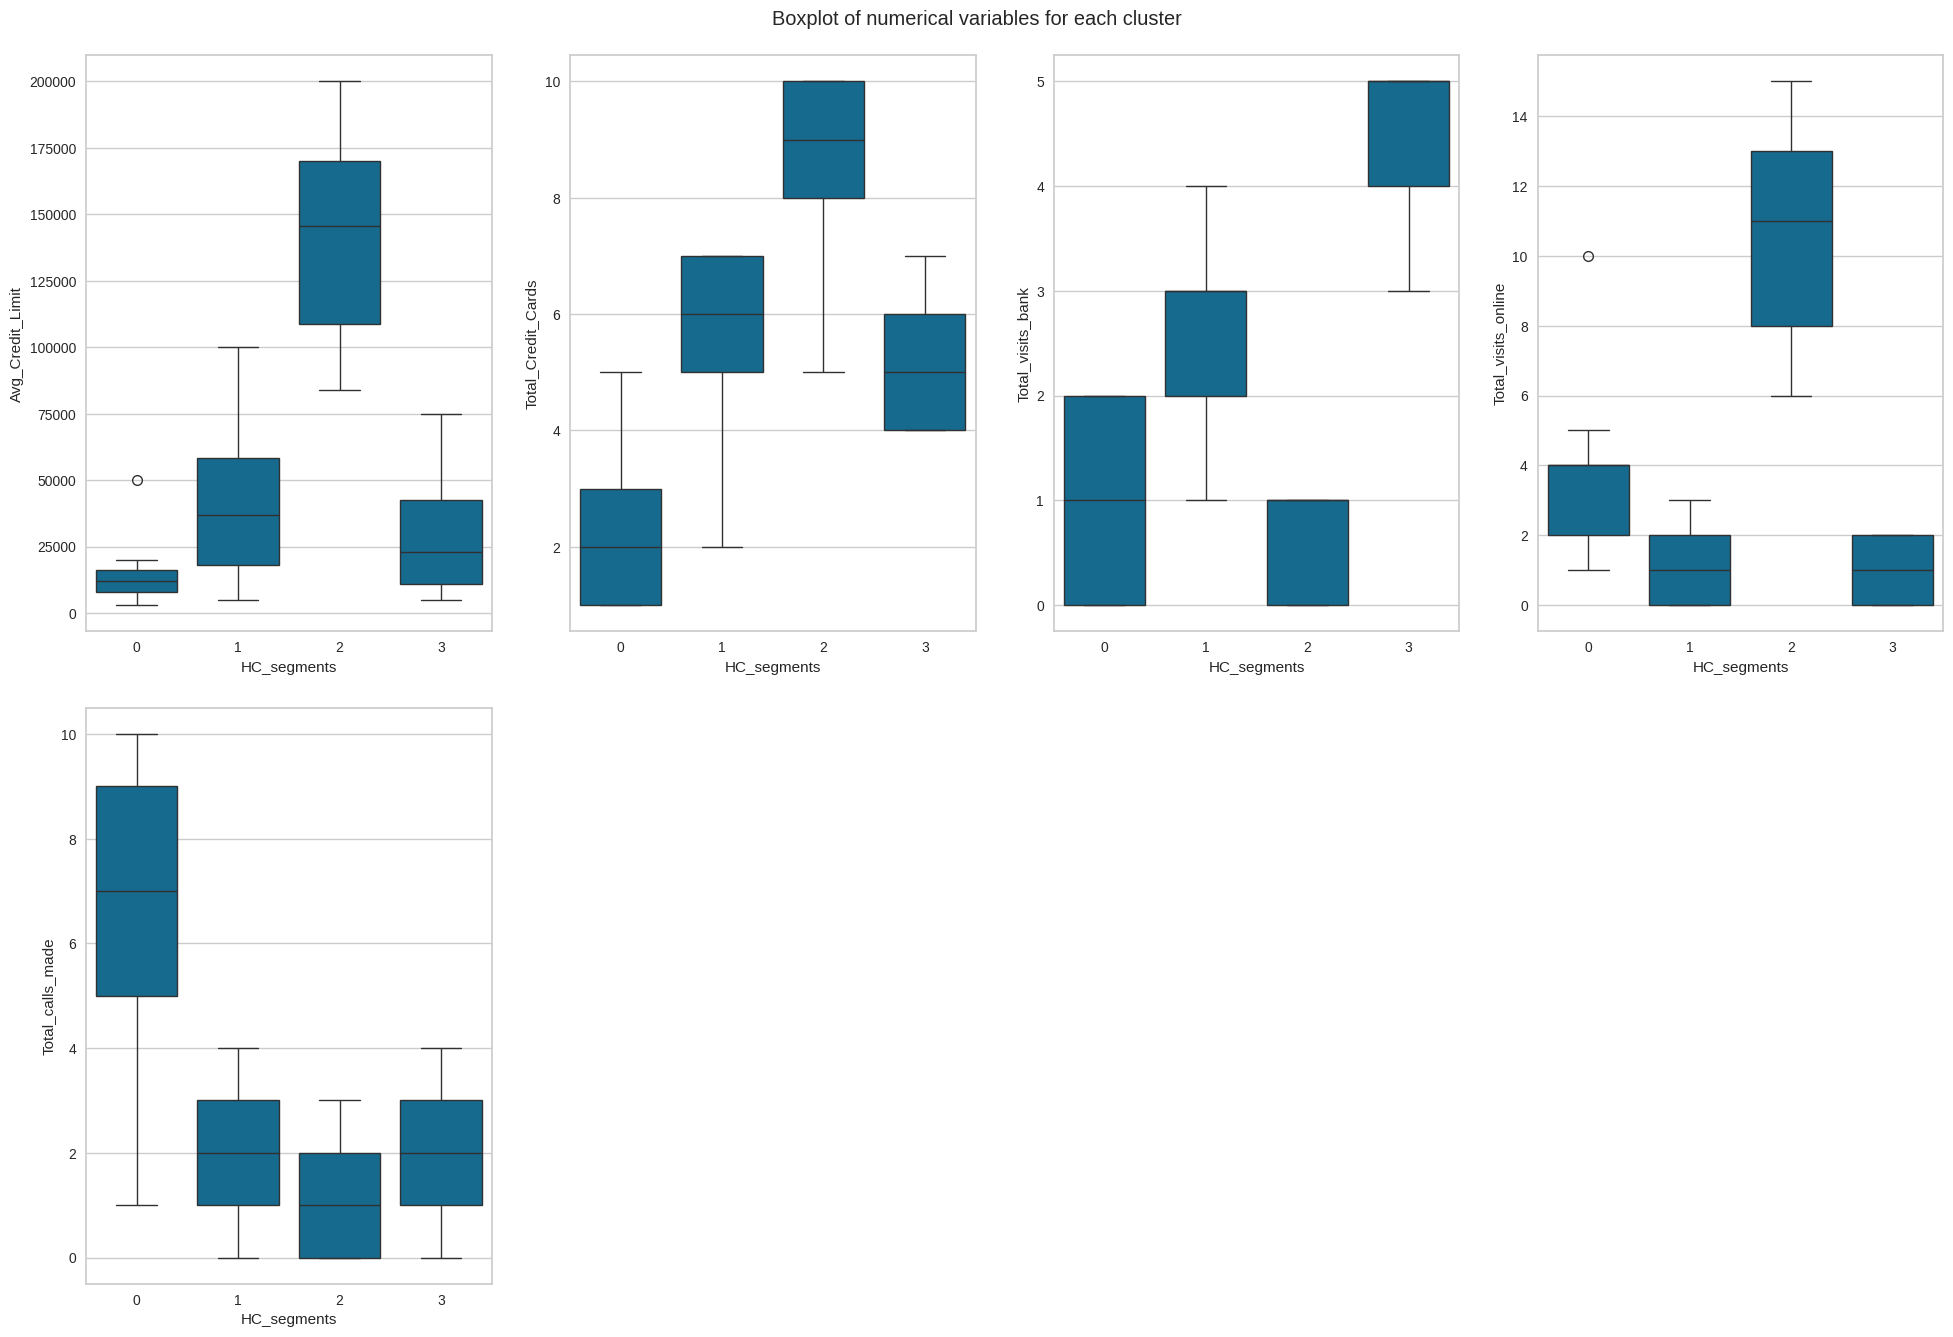

In [60]:
plt.figure(figsize=(20, 20))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(cols_list):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=hc_df, x="HC_segments", y=variable)

plt.tight_layout(pad=2.0)

### Insights

#### Cluster 0
- Avg_Credit_Limit: Customers in this segment have the lowest average credit limits, typically between 25,000 and 50,000.
- Total_Credit_Cards: This group holds around 4-6 credit cards on average.
- Total_visits_bank: Customers in this cluster make the most visits to the bank, with a median of 4 visits. There’s notable variability, indicating diverse banking habits.
- Total_visits_online: They have the fewest online banking interactions, averaging about 2-4 visits.
- Total_calls_made: This group tends to make a higher number of calls, averaging around 8 calls.

General Insight: Cluster 0 represents customers with lower credit limits who rely heavily on phone communication and traditional banking, visiting banks frequently but utilizing online services minimally.


#### Cluster 1
- Avg_Credit_Limit: Customers in this cluster have similar low credit limits, generally around $25,000.
- Total_Credit_Cards: They typically possess 2-3 credit cards, which is fewer compared to other clusters.
- Total_visits_bank: This group makes the least bank visits, averaging 1 visit.
- Total_visits_online: Online visits are also low, usually around 1-2 visits.
- Total_calls_made: Customers here make the fewest calls, averaging 2-4 calls.

General Insight: Cluster 1 consists of customers with the lowest engagement overall, showcasing minimal credit card usage and low interaction with both banking channels.

####Cluster 2
- Avg_Credit_Limit: This cluster includes customers with significantly higher average credit limits, generally ranging from $75,000 to $150,000.
- Total_Credit_Cards: Customers in this segment possess a higher number of credit cards, typically between 6-8 cards.
- Total_visits_bank: Their bank visits are lower, averaging 1 visit.
- Total_visits_online: They are more active in online banking, averaging about 10-12 visits.
- Total_calls_made: This group makes fewer phone calls, typically around 2-4 calls.

General Insight: Cluster 2 is characterized by affluent customers with higher credit limits and card usage. They prefer online banking over physical visits and phone interactions.

####Cluster 3
- Avg_Credit_Limit: Customers in this cluster have moderate credit limits, generally between $50,000 to $75,000.
- Total_Credit_Cards: They typically have around 4-5 credit cards.
- Total_visits_bank: Their banking behavior is moderate, with about 1-2 visits.
- Total_visits_online: Online visits are also moderate, averaging 2-4 visits.
- Total_calls_made: Phone calls are average, typically around 2-4 calls.

General Insight: Cluster 3 represents a balanced group of customers with moderate credit limits and interaction with both banking and online services.

**Summary of Customer Clusters:**
* Cluster 0: Customers with low credit limits and high engagement with bank visits and calls.
* Cluster 1: Customers showing minimal banking activity and engagement.
* Cluster 2: Affluent customers favoring online banking with high credit limits and multiple cards.
* Cluster 3: Customers with moderate profiles, showcasing balanced engagement across banking channels.

# **K-means vs Hierarchical Clustering**

In [61]:
clusters = km_df.K_means_segments.unique().tolist()
for cl in clusters:
    print(
        "The",
        km_df[km_df["K_means_segments"] == cl]["Customer Key"].nunique(),
        "customers in cluster",
        cl,
        "are:",
    )
    print(km_df[km_df["K_means_segments"] == cl]["Customer Key"].unique())
    print("-" * 100, "\n")



The 384 customers in cluster 0 are:
[87073 17341 40496 54838 35254 46635 97825 83125 35483 15129 83290 56486
 31903 45909 14263 46813 81878 35549 85799 39122 81531 69965 18595 44398
 32352 40898 27101 33457 45088 23302 27408 65372 21531 56843 17165 89328
 20072 71402 47496 24808 17036 67193 34423 97109 55382 51811 53936 66504
 53207 18514 51319 36340 36934 95925 49771 22919 21233 74544 52025 45652
 73952 49418 77026 49331 75775 54906 94666 11698 34677 95610 41380 38033
 85337 38994 67911 92956 77641 57565 53814 30712 19785 31384 16374 50878
 78002 83459 91987 51552 24998 45673 11596 87485 28414 81863 33240 11466
 23881 44645 49844 92782 22824 26767 26678 50412 17933 34495 47437 22610
 41159 64672 62483 85614 96548 19137 69028 70779 38244 67046 64897 46223
 36628 17565 77381 11799 81940 66706 87838 94437 33790 44402 29886 66804
 47866 61996 15318 89635 71681 71862 96186 22348 36243 88807 82376 98126
 80347 17649 62807 92522 57459 44579 45476 61994 11398 24702 27824 45878
 72431 19215 23

In [62]:
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [63]:
clusters = hc_df.HC_segments.unique().tolist()
for cl in clusters:
    print(
        "The",
        hc_df[hc_df["HC_segments"] == cl]["Customer Key"].nunique(),
        "customers in cluster",
        cl,
        "are:",
    )
    print(hc_df[hc_df["HC_segments"] == cl]["Customer Key"].unique())
    print("-" * 100, "\n")

The 191 customers in cluster 1 are:
[87073 17341 40496 54838 35254 97825 35483 45909 14263 46813 39122 81531
 18595 40898 27101 45088 65372 56843 20072 47496 53936 66504 51319 21233
 74544 45652 77026 54906 94666 11698 34677 57565 31384 16374 91987 51552
 24998 45673 81863 23881 44645 17933 47437 85614 96548 19137 69028 64897
 36628 17565 11799 81940 66706 87838 47866 61996 15318 89635 71862 82376
 17649 44579 61994 24702 27824 45878 72431 19215 85122 55060 31113 68439
 88207 96929 78618 31551 29864 45440 97954 90189 55090 88884 45808 53932
 65908 25321 48602 48657 49913 53002 82807 93496 37252 41287 52460 58019
 87219 36839 12663 48667 42887 14439 81166 14816 11265 84351 89446 64774
 53166 45341 36504 15798 84360 46776 67258 44804 29919 74446 36632 76024
 75065 51682 56367 95147 23102 49690 20043 53552 62530 41741 61216 83192
 82023 64550 17382 27117 21717 81910 76492 43000 48692 43034 13140 91242
 63710 90860 58708 57451 43679 26334 47848 17377 51771 83585 68040 34775
 85645 44157 75

In [64]:
hc_df_profiling.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_segments,,,,,,
0,12151.111111,2.422222,0.937778,3.546667,6.857778,225
1,38298.429319,5.670157,2.523560,0.947644,2.099476,191
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,29474.226804,5.365979,4.448454,1.010309,1.891753,194


### **Observations**

K-means Clustering:

- Cluster 0: 384 customers
- Cluster 1: 224 customers
- Cluster 2: 50 customers

Hierarchical Clustering:

- Cluster 0: 225 customers
- Cluster 1: 191 customers
- Cluster 2: 50 customers
- Cluster 3: 193 customers

### Cluster Size:
- K-Means produces three clusters, while Hierarchical produces four, indicating more granularity in the latter.
- K-Means shows a large concentration in Cluster 0 (386 customers), whereas Hierarchical has its largest cluster (Cluster 0) at 225 customers, indicating a more balanced distribution across clusters.

### Customer Characteristics:
* Cluster 0 (K-Means) vs. Cluster 1 (Hierarchical):

  K-Means Cluster 0 has a significantly lower average credit limit (33,782.38) compared to Hierarchical Cluster 1 (38,298.43). However, both have similar total credit card counts and customer behavior patterns.
* Cluster 1 (K-Means) vs. Cluster 0 (Hierarchical):

  K-Means Cluster 1 exhibits low credit limits (12,174.11) and high call volume (6.87), whereas Hierarchical Cluster 0 has a similar credit limit (12,151.11) and call volume (6.86). This indicates consistency in customer behavior across both models.
* Cluster 2 (K-Means) vs. Cluster 2 (Hierarchical):

  Both clusters exhibit similar characteristics, indicating a strong group of high-spending customers with significant engagement online.
* Hierarchical Cluster 3:

  Introduced by Hierarchical clustering, this cluster (with 194 customers) has an average credit limit of 29,474.23 and a higher number of bank visits (4.45). This segment can be further explored, as it represents customers who may have different needs and behaviors than those identified by K-Means.

# **Actionable Insights & Recommendations**

**Cluster Characteristics:**

K-means Clustering:

* Cluster 0: Contains the majority of customers (386) with an average credit limit of approximately 33,782 and a significant number of credit cards (5.5). This group makes frequent visits to the bank (3.49) but fewer online visits and calls.
* Cluster 1: Contains 224 customers, with a lower average credit limit (12,174) and fewer credit cards (2.4). This group shows a higher tendency for online interactions (3.55 calls made).
* Cluster 2: A small group (50 customers) with the highest average credit limit (141,040) and the most credit cards (8.74). They are very active online (10.9 visits).

Hierarchical Clustering:

* Cluster 0: Similar to K-means Cluster 1, it has 225 customers with a low average credit limit (12,151) and more online interactions.
* Cluster 1: Similar to K-means Cluster 0 but contains 191 customers with a higher average credit limit (38,298).
* Cluster 2: Matches K-means Cluster 2 (50 customers, 141,040).
* Cluster 3: Contains 194 customers with an average credit limit of 29,474, moderate banking activity, and slightly fewer online interactions compared to Cluster 1.


### Recommendations


Targeted Marketing Strategies:

- Cluster 0 (High Credit, High Bank Visits): Implement a loyalty program targeting this group, encouraging them to engage with both online and offline services. Offer incentives for online transactions to increase engagement.
- Cluster 1 (Low Credit, High Online Engagement): Focus on educational content and promotions to increase their credit limits and encourage more offline engagement. Consider offering financial literacy workshops that explain the benefits of having multiple credit cards.
- Cluster 2 (Ultra High Credit): Develop exclusive products tailored for high-net-worth individuals, such as premium credit cards with enhanced benefits. Consider personalized financial advisory services.
- Cluster 3 (Moderate Credit with Mixed Behavior): Encourage this group to increase their credit card usage and online banking through targeted campaigns that highlight convenience and potential rewards.
Customer Engagement:

Use insights from both clusters to create personalized communication strategies. For example, tailor emails and promotions based on the preferred interaction channel of each cluster (online vs. in-person).
Increase engagement through feedback surveys to understand their needs better and adapt products or services accordingly.

Cross-Selling Opportunities:

Identify customers who have low credit limits but high engagement (Cluster 1 and Cluster 0 in K-means). Offer tailored products that can help them increase their limits and credit score, such as secured credit cards or credit-building loans.

Data-Driven Decision Making:


Continuously monitor customer behavior and update clustering models regularly to identify emerging trends. This will ensure that strategies remain relevant and effective.
Utilize additional variables in future clustering to enhance customer segmentation, such as customer demographics or transaction behaviors.

Risk Management:

For high-credit customers in Cluster 2, ensure risk assessment measures are in place, considering their high transaction volumes and engagement levels.
